In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
dtype_spec = {2:str, 3:str, 6:str, 7:str, 10:str, 11:str, 12:str, 13:str, 14:str, 15:str, 16:str, 17:str, 20:str}
entities_df = pd.read_csv("nodes-entities.csv", dtype=dtype_spec)

In [3]:
entities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814344 entries, 0 to 814343
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   node_id                   814344 non-null  int64  
 1   name                      814315 non-null  object 
 2   original_name             389522 non-null  object 
 3   former_name               6837 non-null    object 
 4   jurisdiction              806780 non-null  object 
 5   jurisdiction_description  806782 non-null  object 
 6   company_type              138751 non-null  object 
 7   address                   299323 non-null  object 
 8   internal_id               389522 non-null  float64
 9   incorporation_date        788470 non-null  object 
 10  inactivation_date         144773 non-null  object 
 11  struck_off_date           343843 non-null  object 
 12  dorm_date                 20207 non-null   object 
 13  status                    358036 non-null  o

In [4]:
entities_df.jurisdiction_description.unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'Bahamas', 'British Anguilla',
       'Seychelles', 'Niue', 'Uruguay', 'British Virgin Islands',
       'Hong Kong', 'New Zealand', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica', 'Undetermined', 'Cayman',
       'Recorded in leaked files as "fund"', 'Labuan', 'Marshall Islands',
       'Mauritius', 'St. Lucia', 'Malaysia', 'Dubai', 'Vanuatu',
       'Cook Islands', 'Bermuda', 'Brunei', 'Liberia',
       'United States Of America', 'China', 'Thailand', 'Netherlands',
       'Ireland', 'Aruba', 'United Arab Emirates', 'Antigua and Barbuda',
       'Anguilla', 'Netherlands Antilles', 'Barbados', 'Lebanon',
       'Cayman Islands', 'Ghana', 'Grenada', 'Guernsey', 'Gibraltar',
       'Isle of Man', 'Saint Kitts and Nevis', 'Liechtenstein',
       'Luxembourg', 'Turks and Caicos Islands',
       'United States of America', 'State of Delaware',
       'Saint Vince

In [5]:
# 1. Normalize status column
entities_df['status_normalized'] = entities_df['status'].str.lower().str.strip()

# 2. Create a boolean column to identify active/open status
entities_df['is_active'] = entities_df['status_normalized'].str.contains('active', na=False) | entities_df['status_normalized'].str.contains('open', na=False)

# 3. Parse date columns to datetime (if not already done)
entities_df['incorporation_date'] = pd.to_datetime(entities_df['incorporation_date'], errors='coerce')
entities_df['inactivation_date'] = pd.to_datetime(entities_df['inactivation_date'], errors='coerce')
entities_df['struck_off_date'] = pd.to_datetime(entities_df['struck_off_date'], errors='coerce')

# 4. Create a unified 'end_date' that prioritizes 'inactivation_date' over 'struck_off_date'
entities_df['end_date'] = entities_df['inactivation_date'].combine_first(entities_df['struck_off_date'])

# 5. Build boolean mask for entities with proper date metadata
has_valid_incorp = entities_df['incorporation_date'].notna()
has_valid_end_date = entities_df['end_date'].notna()

# 6. Filter condition:
# Keep entity if it has incorporation date AND
# (has inactivation/struck_off date OR is active/open)
valid_entities_mask = has_valid_incorp & (has_valid_end_date | entities_df['is_active'])

# 7. Filter dataframe
entities_df_filtered = entities_df[valid_entities_mask].copy()

print(f"Filtered entities count: {entities_df_filtered.shape[0]}")

C:\Users\Justin\AppData\Local\Temp\ipykernel_13816\577356396.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
C:\Users\Justin\AppData\Local\Temp\ipykernel_13816\577356396.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
C:\Users\Justin\AppData\Local\Temp\ipykernel_13816\577356396.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


Filtered entities count: 456945


In [7]:
def normalize_jurisdiction(name):
    if pd.isna(name):
        return ''
    # Lowercase
    name = name.lower()
    
    # Strip whitespace and newlines
    name = name.strip().replace('\n', '')
    
    # Replace 'british anguilla' with 'anguilla'
    if 'british anguilla' in name:
        name = name.replace('british anguilla', 'anguilla')
    
    # Replace 'st.' with 'saint'
    name = name.replace('st.', 'saint')
    # Also replace 'st ' with 'saint ' to catch "St Kitts" without dot
    name = name.replace('st ', 'saint ')
    
    # Replace & with and
    name = name.replace('&', 'and')
    
    # Replace multiple spaces with single space, then strip again
    name = ' '.join(name.split())
    
    # Replace 'u.s.' with 'us'
    name = name.replace('u.s.', 'us')
    
    # Fix specific misspellings / variants
    # Cook Islands might appear as 'cookislands', so fix it:
    if 'cookislands' in name:
        name = name.replace('cookislands', 'cook islands')

    # Normalize nevis alone to full name if possible
    if name == 'nevis':
        name = 'saint kitts and nevis'
    
    return name

# Normalize jurisdiction_description in your dataframe
entities_df_filtered['jurisdiction_norm'] = entities_df_filtered['jurisdiction_description'].apply(normalize_jurisdiction)

# Example: Normalize your OECD blacklist entries with same function
oecd_2000_blacklist_raw = [
    'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Bahrain',
    'Barbados', 'Belize', 'British Virgin Islands', 'Cook Islands', 'Dominica',
    'Gibraltar', 'Grenada', 'Guernsey', 'Isle of Man', 'Jersey', 'Liberia',
    'Liechtenstein', 'Maldives', 'Marshall Islands', 'Monaco', 'Montserrat',
    'Nauru', 'Netherlands Antilles', 'Niue', 'Panama', 'Samoa', 'Seychelles',
    'St. Lucia', 'St. Kitts and Nevis', 'St. Vincent and the Grenadines', 'Tonga',
    'Turks and Caicos Islands', 'U.S. Virgin Islands', 'Vanuatu'
]

oecd_2000_blacklist = [normalize_jurisdiction(c) for c in oecd_2000_blacklist_raw]

# Now you can filter using the normalized column and normalized blacklist:
blacklist_entities_df = entities_df_filtered[entities_df_filtered['jurisdiction_norm'].isin(oecd_2000_blacklist)].copy()

print(f"Number of entities in blacklisted jurisdictions with proper date data: {blacklist_entities_df.shape[0]}")

Number of entities in blacklisted jurisdictions with proper date data: 435835


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Entities in OECD 2000 Blacklist Jurisdictions: Incorporation & Inactivation by Year')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Entities')

(1980.0, 2020.0)

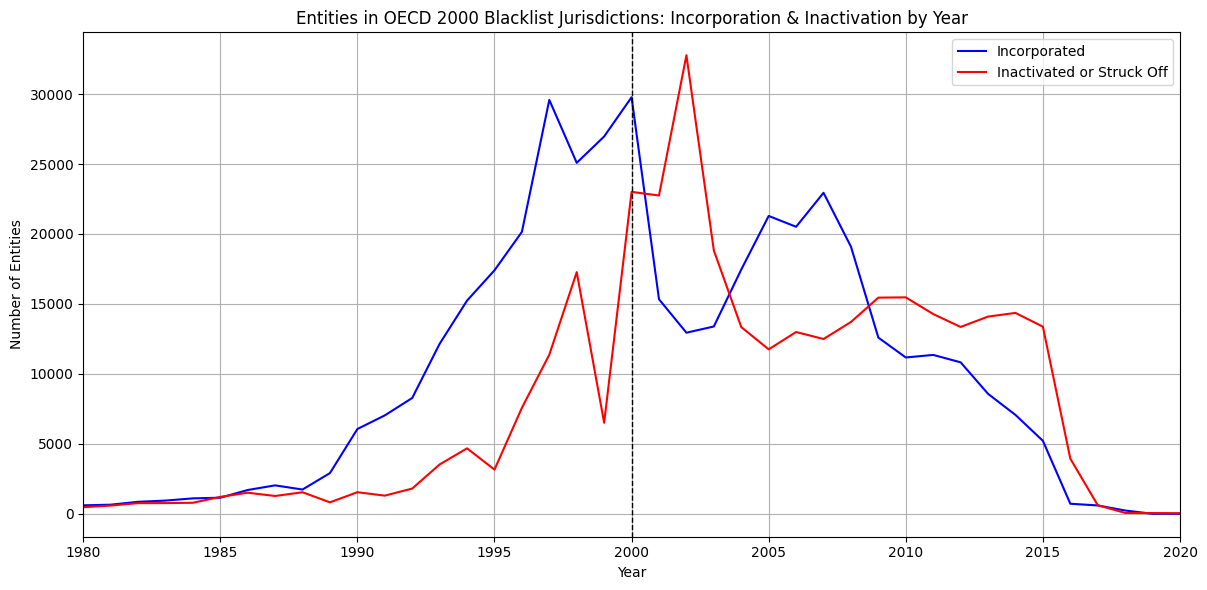

In [8]:
## time series line graph

# Assume your entities_df has these columns, normalized and ready:
# 'incorporation_date', 'inactivation_date', 'struck_off_date', 'jurisdiction_norm'



# get years
blacklist_entities_df['incorp_year'] = blacklist_entities_df['incorporation_date'].dt.year


# Choose earliest date between inactivation and struck_off for "end" events
blacklist_entities_df['end_date'] = blacklist_entities_df[['inactivation_date', 'struck_off_date']].min(axis=1)
blacklist_entities_df['end_year'] = blacklist_entities_df['end_date'].dt.year

# Group by year and count unique entities incorporated by year
incorp_counts = blacklist_entities_df.groupby('incorp_year')['node_id'].nunique().sort_index()

# Group by year and count unique entities ended by year
end_counts = blacklist_entities_df.groupby('end_year')['node_id'].nunique().sort_index()

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(incorp_counts.index, incorp_counts.values, label='Incorporated', color='blue')
plt.plot(end_counts.index, end_counts.values, label='Inactivated or Struck Off', color='red')

# Vertical dotted black line at year 2000
plt.axvline(x=2000, color='black', linestyle='--', linewidth=1)

plt.title('Entities in OECD 2000 Blacklist Jurisdictions: Incorporation & Inactivation by Year')
plt.xlabel('Year')
plt.ylabel('Number of Entities')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(1980, 2020)
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='jurisdiction_norm'>

Text(0.5, 1.0, 'Top 10 OECD Blacklist Jurisdictions for Ended Entities (2000–2003)')

Text(0.5, 0, 'Percent of All Ended Entities (2000-2003)')

Text(0, 0.5, 'Jurisdiction')

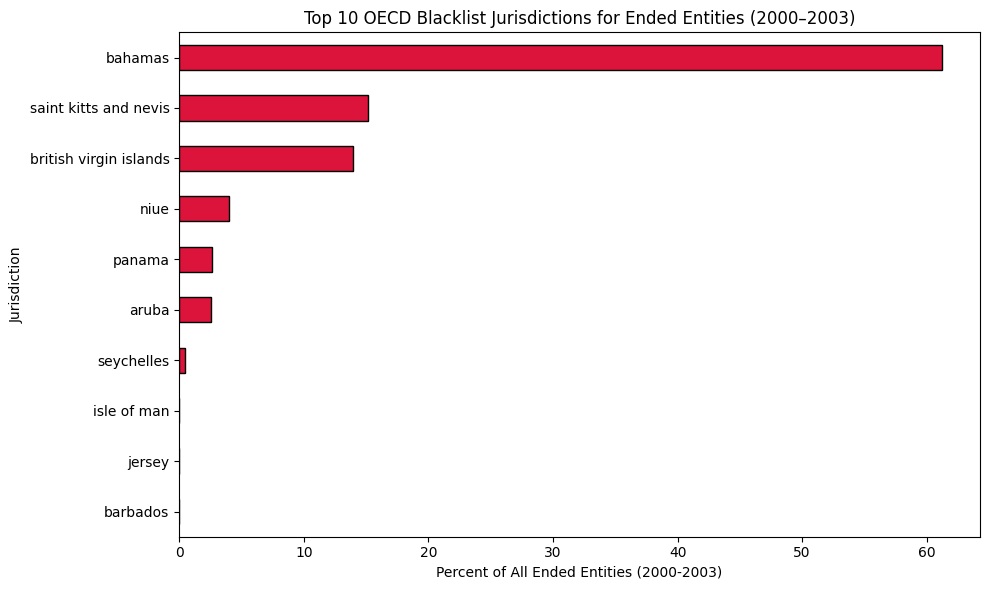

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='jurisdiction_norm'>

Text(0.5, 1.0, 'Top 10 OECD Blacklist Jurisdictions for New Incorporations (2004–2007)')

Text(0.5, 0, 'Percent of all Newly Incorporated Entities (2004-2007)')

Text(0, 0.5, 'Jurisdiction')

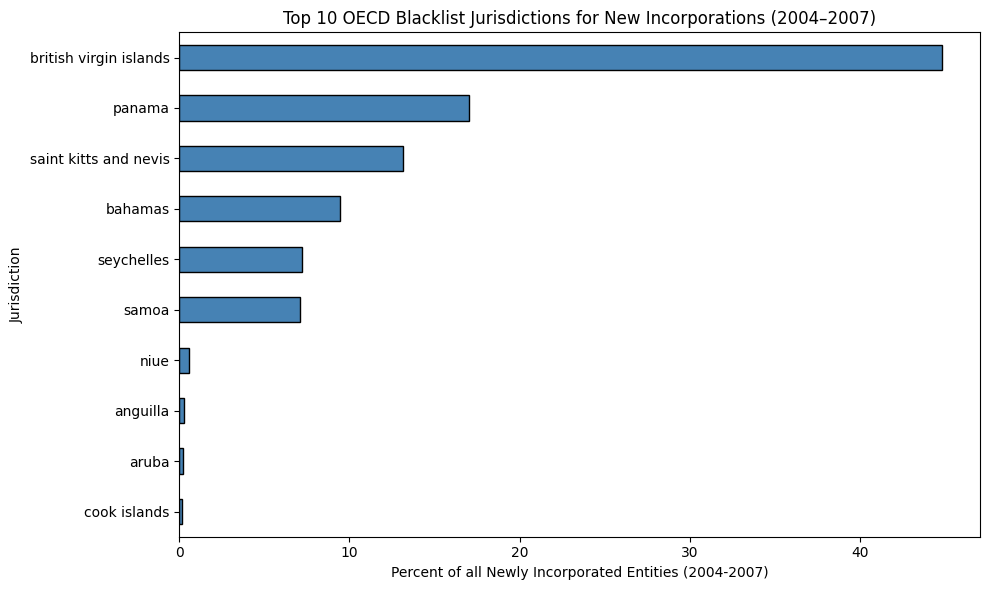

In [24]:
import matplotlib.pyplot as plt

# 1) (Re)compute the year columns
blacklist_entities_df['incorp_year'] = blacklist_entities_df['incorporation_date'].dt.year

# Earliest of inactivation_date and struck_off_date
blacklist_entities_df['end_date'] = blacklist_entities_df[
    ['inactivation_date', 'struck_off_date']
].min(axis=1)
blacklist_entities_df['end_year'] = blacklist_entities_df['end_date'].dt.year

# -------------------------------------------------------------------
# PART A: Top 10 % jurisdictions by ENDED entities (2000–2003)
# -------------------------------------------------------------------

# Filter to the desired end‐year window
ended_00_03 = blacklist_entities_df[
    (blacklist_entities_df['end_year'] >= 2000) &
    (blacklist_entities_df['end_year'] <= 2003)
]

# Count unique node_ids per jurisdiction
ended_counts = ended_00_03.groupby('jurisdiction_norm')['node_id'].nunique()

# Convert to % of total ended in 2000–2003
total_ended = ended_counts.sum()
ended_pct = (ended_counts / total_ended) * 100

# Top 10 jurisdictions by % ended
ended_top10 = ended_pct.sort_values(ascending=False).head(10)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
ended_top10.sort_values().plot(
    kind='barh', color='crimson', edgecolor='black'
)
plt.title('Top 10 OECD Blacklist Jurisdictions for Ended Entities (2000–2003)')
plt.xlabel('Percent of All Ended Entities (2000-2003)')
plt.ylabel('Jurisdiction')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# PART B: Top 10 % jurisdictions by NEW INCORPORATIONS (2004–2007)
# -------------------------------------------------------------------

# Filter to the desired incorporation‐year window
incorp_04_07 = blacklist_entities_df[
    (blacklist_entities_df['incorp_year'] >= 2004) &
    (blacklist_entities_df['incorp_year'] <= 2007)
]

# Count unique node_ids per jurisdiction
incorp_counts = incorp_04_07.groupby('jurisdiction_norm')['node_id'].nunique()

# Convert to % of total incorporations in 2004–2007
total_incorp = incorp_counts.sum()
incorp_pct = (incorp_counts / total_incorp) * 100

# Top 10 jurisdictions by % incorporated
incorp_top10 = incorp_pct.sort_values(ascending=False).head(10)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
incorp_top10.sort_values().plot(
    kind='barh', color='steelblue', edgecolor='black'
)
plt.title('Top 10 OECD Blacklist Jurisdictions for New Incorporations (2004–2007)')
plt.xlabel('Percent of all Newly Incorporated Entities (2004-2007)')
plt.ylabel('Jurisdiction')
plt.tight_layout()
plt.show()

<Axes: ylabel='jurisdiction_norm'>

Text(0.5, 1.0, 'Top 10 Jurisdictions of Incorporation Before 2000')

Text(0.5, 0, 'Percentage of All Entities Incorporated Before 2000')

Text(0, 0.5, 'Jurisdiction')

<Axes: ylabel='jurisdiction_norm'>

Text(0.5, 1.0, 'Top 10 Jurisdictions of Incorporation After 2007')

Text(0.5, 0, 'Percentage of All Entities Incorporated After 2007')

Text(0, 0.5, '')

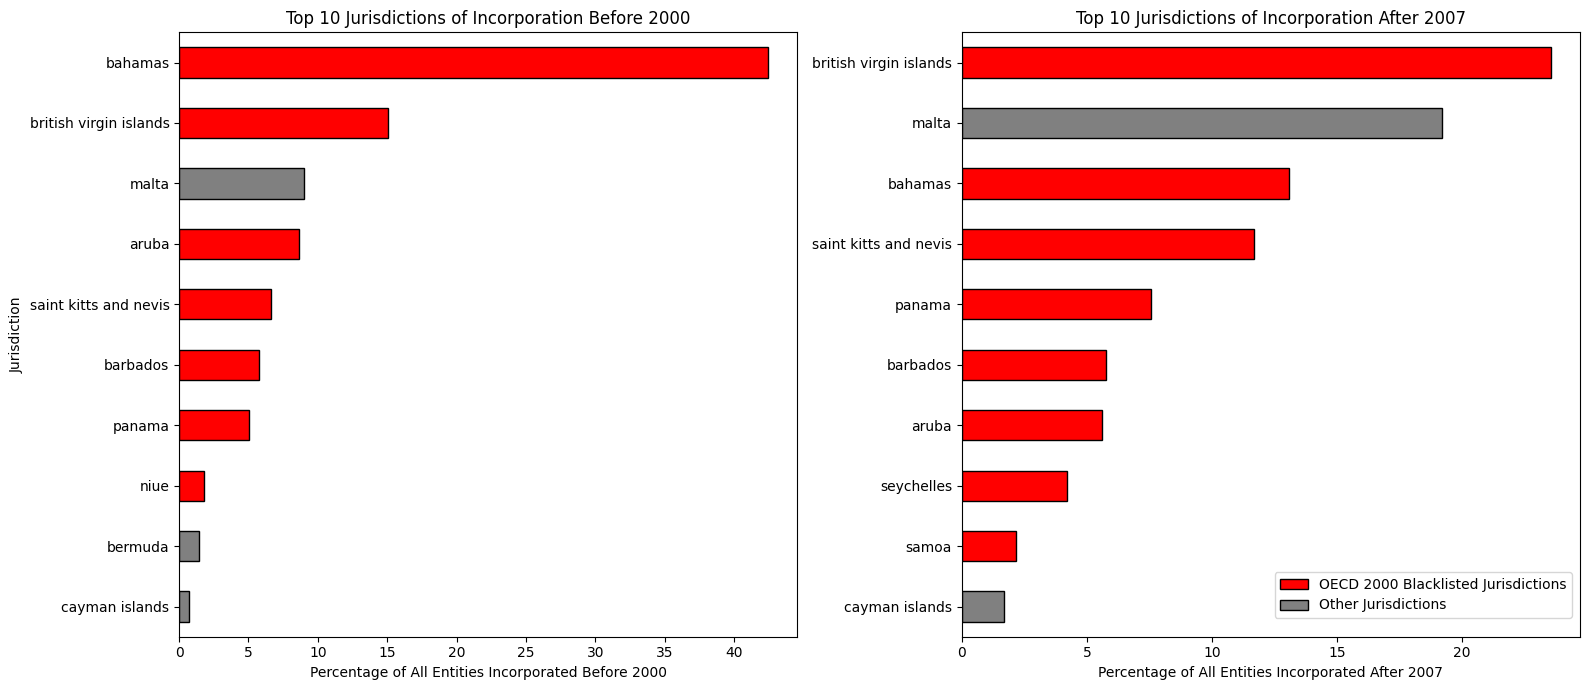

In [14]:

# Filter entities_df to keep rows where incorporation_date is present
entities_df['incorporation_date'] = pd.to_datetime(entities_df['incorporation_date'], errors='coerce')
entities_with_incorp = entities_df[entities_df['incorporation_date'].notna()].copy()

# Normalize jurisdiction_description as before
def normalize_jurisdiction(name):
    if pd.isna(name):
        return ''
    name = name.lower()
    name = name.strip().replace('\n', '')
    if 'british anguilla' in name:
        name = name.replace('british anguilla', 'anguilla')
    name = name.replace('st.', 'saint')
    name = name.replace('st ', 'saint ')
    name = name.replace('&', 'and')
    name = ' '.join(name.split())
    name = name.replace('u.s.', 'us')
    if 'cookislands' in name:
        name = name.replace('cookislands', 'cook islands')
    if name == 'nevis':
        name = 'saint kitts and nevis'
    return name

entities_with_incorp['jurisdiction_norm'] = entities_with_incorp['jurisdiction_description'].apply(normalize_jurisdiction)

# Define cutoff years for periods
pre_cutoff = 2000
post_cutoff = 2007

# Create incorporation year column
entities_with_incorp['incorp_year'] = entities_with_incorp['incorporation_date'].dt.year

# Filter for pre-2000 and post-2007 periods
pre_2000 = entities_with_incorp[entities_with_incorp['incorp_year'] < pre_cutoff]
post_2007 = entities_with_incorp[entities_with_incorp['incorp_year'] > post_cutoff]


# Calculate total unique entities including all jurisdictions (including 'undetermined') if needed
total_pre = pre_2000['node_id'].nunique()
total_post = post_2007['node_id'].nunique()

# Compute unique counts by jurisdiction excluding 'undetermined'
pre_counts = (
    pre_2000[pre_2000['jurisdiction_norm'] != 'undetermined']
    .groupby('jurisdiction_norm')['node_id']
    .nunique()
)
post_counts = (
    post_2007[post_2007['jurisdiction_norm'] != 'undetermined']
    .groupby('jurisdiction_norm')['node_id']
    .nunique()
)
# Convert counts to percentages by dividing by total
pre_counts_percent = (pre_counts / total_pre) * 100
post_counts_percent = (post_counts / total_post) * 100

# Take top 10 jurisdictions by percentage
pre_counts_percent = pre_counts_percent.sort_values(ascending=False).head(10)
post_counts_percent = post_counts_percent.sort_values(ascending=False).head(10)


# Prepare color maps for bars
blacklist_set = set(oecd_2000_blacklist)

def color_map(jurisdictions, blacklist, highlight_color='red', default_color='gray'):
    return [highlight_color if j in blacklist else default_color for j in jurisdictions]

pre_colors = color_map(pre_counts_percent.index, blacklist_set)
post_colors = color_map(post_counts_percent.index, blacklist_set)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)

pre_counts_percent.plot(
    kind='barh',
    ax=axes[0],
    color=pre_colors,
    edgecolor='black'
)
axes[0].invert_yaxis()
axes[0].set_title('Top 10 Jurisdictions of Incorporation Before 2000')
axes[0].set_xlabel('Percentage of All Entities Incorporated Before 2000')
axes[0].set_ylabel('Jurisdiction')

post_counts_percent.plot(
    kind='barh',
    ax=axes[1],
    color=post_colors,
    edgecolor='black'
)
axes[1].invert_yaxis()
axes[1].set_title('Top 10 Jurisdictions of Incorporation After 2007')
axes[1].set_xlabel('Percentage of All Entities Incorporated After 2007')
axes[1].set_ylabel('')


legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='OECD 2000 Blacklisted Jurisdictions'),
    Patch(facecolor='gray', edgecolor='black', label='Other Jurisdictions')
]

fig.legend(
    handles=legend_elements,
    loc='lower right',  # places legend at the bottom right inside the figure
    bbox_to_anchor=(0.99, 0.1),  # anchor point at bottom right corner of the figure
    fontsize='medium',
    frameon=True
)


plt.tight_layout()
plt.show()

In [67]:
entities_df.jurisdiction_description.unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'Bahamas', 'British Anguilla',
       'Seychelles', 'Niue', 'Uruguay', 'British Virgin Islands',
       'Hong Kong', 'New Zealand', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica', 'Undetermined', 'Cayman',
       'Recorded in leaked files as "fund"', 'Labuan', 'Marshall Islands',
       'Mauritius', 'St. Lucia', 'Malaysia', 'Dubai', 'Vanuatu',
       'Cook Islands', 'Bermuda', 'Brunei', 'Liberia',
       'United States Of America', 'China', 'Thailand', 'Netherlands',
       'Ireland', 'Aruba', 'United Arab Emirates', 'Antigua and Barbuda',
       'Anguilla', 'Netherlands Antilles', 'Barbados', 'Lebanon',
       'Cayman Islands', 'Ghana', 'Grenada', 'Guernsey', 'Gibraltar',
       'Isle of Man', 'Saint Kitts and Nevis', 'Liechtenstein',
       'Luxembourg', 'Turks and Caicos Islands',
       'United States of America', 'State of Delaware',
       'Saint Vince

In [66]:
entities_df_filtered.jurisdiction_description.unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'Bahamas', 'British Anguilla',
       'Seychelles', 'Niue', 'Uruguay', 'British Virgin Islands',
       'Hong Kong', 'New Zealand', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica', 'Undetermined', 'Cayman',
       'Recorded in leaked files as "fund"', 'Labuan', 'Marshall Islands',
       'Mauritius', 'St. Lucia', 'Malaysia', 'Dubai', 'Vanuatu',
       'Cook Islands', 'Bermuda', 'United States Of America', 'China',
       'Netherlands', 'Thailand', 'Aruba', 'Barbados',
       'Saint Kitts and Nevis', 'Panama\n', 'Delaware', 'Cayman Islands',
       'Cyprus '], dtype=object)